In [1]:
# This cells is used  to install modules
# !pip install propy3

In [2]:
# EDA and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bioinformatics Tools
from Bio import SeqIO # Python tool for Computational Molecular Biology
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from protlearn.preprocessing import integer_encode
from propy.GetProteinFromUniprot import GetProteinSequence
from propy.CTD import CalculateCTD

# model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# metric, score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# statistics
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

import warnings
warnings.filterwarnings("ignore")

Dataset: <br>
1. Merge Train (1529 AMPs & 1529 non-AMPs) and Benchmark (94 AMPs & 94 non-AMPs) dataset from Reference 2. 
2. Split into 80% Train and 20% Test.

Features:
- 'average_polarity'
- 'size'
- 'hydrophobicity'
- 'molecular_weight'
- 'charge'
- 'second_structure':
  - 'helix_frac'
  - 'turn_frac'
  - 'sheet_frac'
- 'CTD':
  - Compute the composition, transition, and distribution descriptors based on the different properties of AADs (Properties: NormalizedVDWV, Hydrophobicity, Polarity, Polarizability, SecondaryStr, SolventAccessibility, Charge) from Reference 2


### Load peptide sequence from fasta to DataFrame

In [3]:
# SeqIO: Read fasta
fasta = "train_po_ne.fasta"
records = list(SeqIO.parse(fasta, "fasta"))

# Extract info from fasta, convert to DataFrame
data = {'Description': [record.description for record in records],
        'Sequence': [str(record.seq) for record in records]}

train = pd.DataFrame(data)

In [4]:
train

,Description,Sequence
0,amp5_30_1,ACSAG
1,amp5_30_2,AMVGT
2,amp5_30_3,AMVSS
3,amp5_30_4,CPFVC
4,amp5_30_5,SPGGA
...,...,...
3053,nonamp5_30_1525,GWKDWLNKGKEWLKKKGPGIMKAALKAATQ
3054,nonamp5_30_1526,GLFKTLIKGAGKMLGHVAKQFLGSQGQPES
3055,nonamp5_30_1527,GIPCGESCVYIPCTVTALAGCKCKSKVCYN
3056,nonamp5_30_1528,SFSVNPAVDILQHRYMEKVAQNNRNFLNRV


In [5]:
fasta = "test_po.fasta"
records = list(SeqIO.parse(fasta, "fasta"))
test_po = {'Description': [record.description for record in records],
        'Sequence': [str(record.seq) for record in records]}

df_test_po = pd.DataFrame(test_po)

In [6]:
df_test_po

,Description,Sequence
0,test_po_80cdhit_1,ETWRTEAPSATGQASSLLGGRLLGQ
1,test_po_80cdhit_2,LGGIVSAVKKIVDFLG
2,test_po_80cdhit_3,GRKKRRQRRRGGWMWVTNLRTD
3,test_po_80cdhit_4,FAKLAKKALAKLL
4,test_po_80cdhit_5,KIAKVALAKLGIGAVLKVLTTGL
...,...,...
89,test_po_80cdhit_90,KAQIRAMECNIL
90,test_po_80cdhit_91,LRVRLASHLRKLRKRLLRDADDLQKRLAVY
91,test_po_80cdhit_92,VNWKKIILGKIIKVVK
92,test_po_80cdhit_93,PAARKAARWAWRMLKKGA


In [7]:
fasta = "test_ne.fasta"
records = list(SeqIO.parse(fasta, "fasta"))
test_ne = {'Description': [record.description for record in records],
        'Sequence': [str(record.seq) for record in records]}
df_test_ne = pd.DataFrame(test_ne)

In [8]:
df_test_ne

,Description,Sequence
0,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,NYIYSGHNYHQ
1,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,DPNATIIMLGTGTGIAPFR
2,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,MGQGAVEGQLFYNVQ
3,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,MSQASSSPGEGPSSEAAAISEAEAASGS
4,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,INWKKIASIGKEVLKAL
...,...,...
89,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,ALPNQQTVDYPSFKSNYNFEKPFLYLAR
90,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,AGFVLKGYTKTSQ
91,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,VNQSETPVKHIGKVF
92,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,MSDELIHVVIALGLVISFGLGAITAGVLR


In [9]:
df_test_ne.iloc[0,0]

'unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_ampepTr_cdh8_sample94_1'

In [10]:
test = pd.concat([df_test_po, df_test_ne], ignore_index=True)

In [11]:
test

,Description,Sequence
0,test_po_80cdhit_1,ETWRTEAPSATGQASSLLGGRLLGQ
1,test_po_80cdhit_2,LGGIVSAVKKIVDFLG
2,test_po_80cdhit_3,GRKKRRQRRRGGWMWVTNLRTD
3,test_po_80cdhit_4,FAKLAKKALAKLL
4,test_po_80cdhit_5,KIAKVALAKLGIGAVLKVLTTGL
...,...,...
183,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,ALPNQQTVDYPSFKSNYNFEKPFLYLAR
184,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,AGFVLKGYTKTSQ
185,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,VNQSETPVKHIGKVF
186,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,MSDELIHVVIALGLVISFGLGAITAGVLR


### Preprocessing

In [12]:
# Train dataset

In [13]:
# Convert 'Description' to Label
train['Label'] = train['Description'].apply(lambda x: 0 if 'non' in x else 1)
train = train.drop(columns='Description')

In [14]:
train

,Sequence,Label
0,ACSAG,1
1,AMVGT,1
2,AMVSS,1
3,CPFVC,1
4,SPGGA,1
...,...,...
3053,GWKDWLNKGKEWLKKKGPGIMKAALKAATQ,0
3054,GLFKTLIKGAGKMLGHVAKQFLGSQGQPES,0
3055,GIPCGESCVYIPCTVTALAGCKCKSKVCYN,0
3056,SFSVNPAVDILQHRYMEKVAQNNRNFLNRV,0


In [15]:
# Test dataset

In [16]:
# Convert 'Description' to Label
test['Label'] = test['Description'].apply(lambda x: 1 if 'po' in x else 0)
test = test.drop(columns='Description')

In [17]:
test

,Sequence,Label
0,ETWRTEAPSATGQASSLLGGRLLGQ,1
1,LGGIVSAVKKIVDFLG,1
2,GRKKRRQRRRGGWMWVTNLRTD,1
3,FAKLAKKALAKLL,1
4,KIAKVALAKLGIGAVLKVLTTGL,1
...,...,...
183,ALPNQQTVDYPSFKSNYNFEKPFLYLAR,0
184,AGFVLKGYTKTSQ,0
185,VNQSETPVKHIGKVF,0
186,MSDELIHVVIALGLVISFGLGAITAGVLR,0


In [18]:
total_data = pd.concat([train, test], ignore_index=True)

In [19]:
total_data

,Sequence,Label
0,ACSAG,1
1,AMVGT,1
2,AMVSS,1
3,CPFVC,1
4,SPGGA,1
...,...,...
3241,ALPNQQTVDYPSFKSNYNFEKPFLYLAR,0
3242,AGFVLKGYTKTSQ,0
3243,VNQSETPVKHIGKVF,0
3244,MSDELIHVVIALGLVISFGLGAITAGVLR,0


In [20]:
X = total_data.drop(columns='Label')
y = total_data['Label']

test_size = 0.2
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [21]:
X_train.shape

(2596, 1)

In [22]:
X_test.shape

(650, 1)

In [23]:
X_train

,Sequence
0,GHHPHGHHPHGHHPHGHHHPH
1,YVPPVQKPHPNGPKFPTFP
2,GLPCGESCVFIPCITTVVGCSCKNKVCYND
3,PFNVGGLDKFGTLN
4,WWRELLKKLAFTAAGHLGSVLAAKQSGW
...,...
2591,IDPFVAGVAAEMMQHVYCAASKKC
2592,ADPTFGFTPLGLSEKANLQIMKAYD
2593,GLFLDTLKGLAGKLLQGLKCIKAGCKP
2594,TCESPSHKFKGPCATNRNCES


In [24]:
y_train

0       1
1       1
2       0
3       0
4       0
       ..
2591    1
2592    1
2593    1
2594    1
2595    0
Name: Label, Length: 2596, dtype: int64

In [25]:
X_test

,Sequence
0,FLPAVLRVAAKVVPTVFCLISKKC
1,AAVSLLQNKLAYDGFLSK
2,VIPFVASVAAEMMPHVYCAASRKC
3,ILPILSLIGGLLGK
4,RDWERREFERRQNELRREQEQRREELL
...,...
645,FLGGLIKWKWPWWPWRR
646,VGKTWIKVIRGIGKSKIKWQ
647,FFSMIPKIATGIASLVKNL
648,GIGSAILSAGKSALKGLAKGLAEHFAN


In [26]:
y_test

0      0
1      0
2      1
3      1
4      0
      ..
645    1
646    1
647    0
648    1
649    0
Name: Label, Length: 650, dtype: int64

### Feature Engineering

In [27]:
class Property_Transformer(object):
    
    def __init__(self):
        # Polarity values for amino acids (1 for polar, 0 for nonpolar)
        self.polarity_values = {'A': 0, 'R': 1, 'N': 1, 'D': 1, 'C': 1, 'Q': 1, 'E': 1, 'G': 0, 'H': 1, 'I': 0,
                                'L': 0, 'K': 1, 'M': 0, 'F': 0, 'P': 0, 'S': 1, 'T': 1, 'W': 0, 'Y': 1, 'V': 0}
        
        # reference: charge_values = {'D': -1, 'E': -1, 'K': 1, 'R': 1, 'H': 0.5, 'other aa':0}, charge result is the sum of all the values

        
    def fit(self, X, y=None):
        pass # No training needed
        
    def transform(self, X, y=None):
        X['average_polarity'] = X['Sequence'].apply(self.calculate_average_polarity)
        X['size'] = X['Sequence'].apply(len)
        X['hydrophobicity'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).gravy()) 
        X['molecular_weight'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).molecular_weight())
        X['charge'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).charge_at_pH(7.0))
        X['second_structure'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).secondary_structure_fraction())
        X['second_structure'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).secondary_structure_fraction())
        X[['helix_frac', 'turn_frac', 'sheet_frac']] = X['second_structure'].apply(pd.Series) # split the 'second_structure' column into 3 new columns
        X['Features'] = X['Sequence'].apply(self.calculate_ctd_features)
        X = pd.concat([X, X['Features'].apply(pd.Series)], axis=1)
        X = X.drop(columns=['Features', 'Sequence', 'second_structure'])
        return X
    
    def fit_transform(self, X, y=None):
        return self.transform(X)
    
    def calculate_average_polarity(self, sequence):
        # Calculate polarity for each amino acid in the sequence
        polarities = [self.polarity_values.get(aa, 0) for aa in sequence]
        average_polarity = sum(polarities) / len(sequence)
        return average_polarity

    def calculate_ctd_features(self, sequence):
        # Use propy.CTD.CalculateD to get features for the given sequence
        result = CalculateCTD(sequence)
        return result

In [28]:
ptf = Property_Transformer()
transformed_train = ptf.fit_transform(X_train)
transformed_test = ptf.fit_transform(X_test)
transformed_train

,average_polarity,size,hydrophobicity,molecular_weight,charge,helix_frac,turn_frac,sheet_frac,_PolarizabilityC1,_PolarizabilityC2,...,_HydrophobicityD2001,_HydrophobicityD2025,_HydrophobicityD2050,_HydrophobicityD2075,_HydrophobicityD2100,_HydrophobicityD3001,_HydrophobicityD3025,_HydrophobicityD3050,_HydrophobicityD3075,_HydrophobicityD3100
0,0.619048,21,-2.361905,2417.4922,0.893366,0.000000,0.380952,0.000000,0.190,0.190,...,4.762,23.810,47.619,71.429,100.000,0.000,0.000,0.000,0.000,0.000
1,0.368421,19,-0.926316,2147.4754,1.844279,0.105263,0.473684,0.315789,0.105,0.579,...,5.263,15.789,47.368,68.421,100.000,10.526,10.526,26.316,78.947,94.737
2,0.566667,30,0.563333,3153.7144,-0.295189,0.133333,0.333333,0.366667,0.267,0.600,...,3.333,10.000,40.000,53.333,93.333,6.667,26.667,43.333,60.000,90.000
3,0.357143,14,-0.035714,1478.6470,-0.041349,0.214286,0.500000,0.428571,0.357,0.429,...,7.143,7.143,35.714,42.857,85.714,14.286,14.286,28.571,50.000,92.857
4,0.357143,28,0.085714,3125.6248,2.847079,0.500000,0.178571,0.392857,0.393,0.286,...,35.714,46.429,57.143,78.571,96.429,3.571,7.143,32.143,60.714,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2591,0.416667,24,0.504167,2570.0385,-0.171592,0.416667,0.166667,0.250000,0.333,0.375,...,12.500,25.000,41.667,70.833,87.500,4.167,16.667,33.333,54.167,100.000
2592,0.440000,25,-0.160000,2728.0795,-1.198890,0.400000,0.320000,0.360000,0.400,0.360,...,4.000,12.000,32.000,52.000,96.000,20.000,20.000,40.000,72.000,84.000
2593,0.370370,27,0.433333,2786.4452,3.736425,0.518519,0.259259,0.370370,0.333,0.444,...,3.704,22.222,40.741,62.963,100.000,7.407,11.111,37.037,66.667,92.593
2594,0.761905,21,-1.180952,2296.5199,0.459281,0.238095,0.380952,0.142857,0.333,0.429,...,4.762,19.048,33.333,57.143,100.000,9.524,9.524,42.857,61.905,90.476


In [29]:
transformed_train.shape

(2596, 155)

In [30]:
transformed_test.shape

(650, 155)

In [31]:
transformed_train.head()

,average_polarity,size,hydrophobicity,molecular_weight,charge,helix_frac,turn_frac,sheet_frac,_PolarizabilityC1,_PolarizabilityC2,...,_HydrophobicityD2001,_HydrophobicityD2025,_HydrophobicityD2050,_HydrophobicityD2075,_HydrophobicityD2100,_HydrophobicityD3001,_HydrophobicityD3025,_HydrophobicityD3050,_HydrophobicityD3075,_HydrophobicityD3100
0,0.619048,21,-2.361905,2417.4922,0.893366,0.000000,0.380952,0.000000,0.190,0.190,...,4.762,23.810,47.619,71.429,100.000,0.000,0.000,0.000,0.000,0.000
1,0.368421,19,-0.926316,2147.4754,1.844279,0.105263,0.473684,0.315789,0.105,0.579,...,5.263,15.789,47.368,68.421,100.000,10.526,10.526,26.316,78.947,94.737
2,0.566667,30,0.563333,3153.7144,-0.295189,0.133333,0.333333,0.366667,0.267,0.600,...,3.333,10.000,40.000,53.333,93.333,6.667,26.667,43.333,60.000,90.000
3,0.357143,14,-0.035714,1478.6470,-0.041349,0.214286,0.500000,0.428571,0.357,0.429,...,7.143,7.143,35.714,42.857,85.714,14.286,14.286,28.571,50.000,92.857
4,0.357143,28,0.085714,3125.6248,2.847079,0.500000,0.178571,0.392857,0.393,0.286,...,35.714,46.429,57.143,78.571,96.429,3.571,7.143,32.143,60.714,100.000


In [32]:
df_train = transformed_train
df_test = transformed_test

In [33]:
X_train = df_train.copy()
X_test = df_test.copy()

### Random Forest

In [34]:
rf = RandomForestClassifier(
                            random_state=42, 
                            n_jobs=-1,
#                             n_estimators=200,
#                             max_depth=10,
#                             min_samples_split=5,
#                             min_samples_leaf=2,
#                             bootstrap=True
                           )

rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

report = classification_report(y_train, y_train_pred)
print(report)

report = classification_report(y_test, y_test_pred)
print(report)

y_train_proba = rf.predict_proba(X_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_proba)
print('Train AUC: %.3f' % roc_auc_train)

auc_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
average_auc = np.mean(auc_scores)
# print("AUC Scores:", auc_scores)
print("Average Train AUC-ROC from CV:", average_auc)

y_test_proba = rf.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print('Test AUC: %.3f' % roc_auc_test)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1331
           1       0.92      0.95      0.93      1265

    accuracy                           0.93      2596
   macro avg       0.93      0.93      0.93      2596
weighted avg       0.93      0.93      0.93      2596

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       292
           1       0.76      0.68      0.72       358

    accuracy                           0.71       650
   macro avg       0.71      0.71      0.71       650
weighted avg       0.71      0.71      0.71       650

Train AUC: 0.991
Average Train AUC-ROC from CV: 0.7586222239437472
Test AUC: 0.747


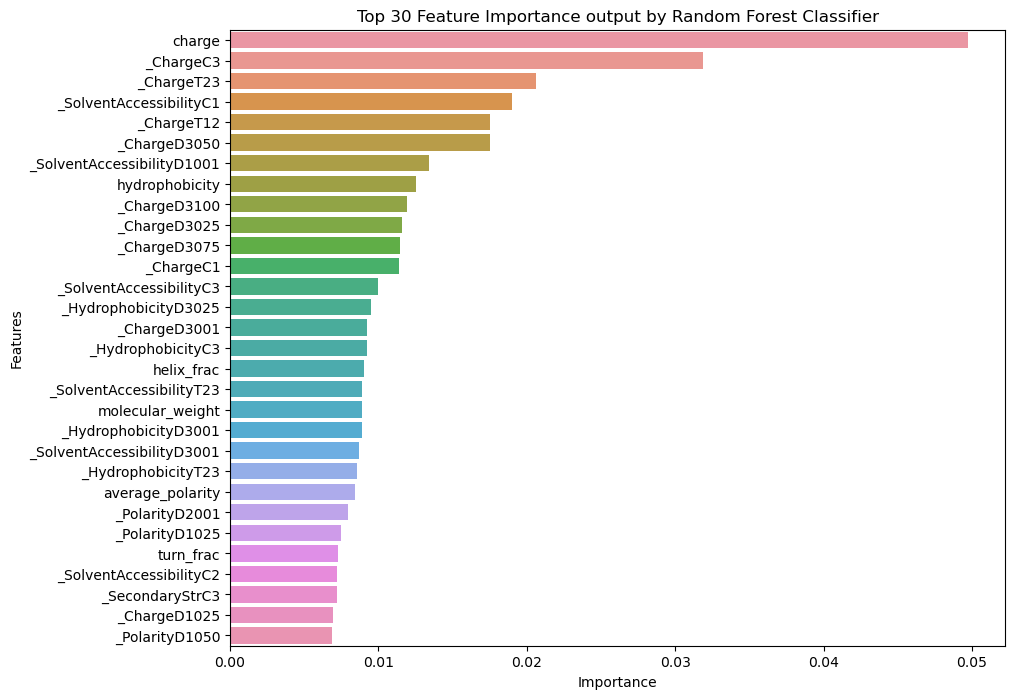

Top 30 Features: ['charge', '_ChargeC3', '_ChargeT23', '_SolventAccessibilityC1', '_ChargeT12', '_ChargeD3050', '_SolventAccessibilityD1001', 'hydrophobicity', '_ChargeD3100', '_ChargeD3025', '_ChargeD3075', '_ChargeC1', '_SolventAccessibilityC3', '_HydrophobicityD3025', '_ChargeD3001', '_HydrophobicityC3', 'helix_frac', '_SolventAccessibilityT23', 'molecular_weight', '_HydrophobicityD3001', '_SolventAccessibilityD3001', '_HydrophobicityT23', 'average_polarity', '_PolarityD2001', '_PolarityD1025', 'turn_frac', '_SolventAccessibilityC2', '_SecondaryStrC3', '_ChargeD1025', '_PolarityD1050']


In [35]:
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['Importance']) # Create a DataFrame with feature importances
sorted_feature_importances = feature_importances.sort_values(by='Importance', ascending=False) # Sort the DataFrame by importance in ascending order
top_30_features = sorted_feature_importances.head(30)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y=top_30_features.index, data=top_30_features)

plt.title('Top 30 Feature Importance output by Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Export the feature names to a Python list
top_30_features_list = top_30_features.index.tolist()

# Print or use the list as needed
print("Top 30 Features:", top_30_features_list)

### Random Forest after tunning features, hyperparameters

In [36]:
X_train = X_train[top_30_features_list]
X_test = X_test[top_30_features_list]

In [37]:
X_train.head()

,charge,_ChargeC3,_ChargeT23,_SolventAccessibilityC1,_ChargeT12,_ChargeD3050,_SolventAccessibilityD1001,hydrophobicity,_ChargeD3100,_ChargeD3025,...,_SolventAccessibilityD3001,_HydrophobicityT23,average_polarity,_PolarityD2001,_PolarityD1025,turn_frac,_SolventAccessibilityC2,_SecondaryStrC3,_ChargeD1025,_PolarityD1050
0,0.893366,0.000,0.000,0.190,0.000,0.000,4.762,-2.361905,0.000,0.000,...,9.524,0.000,0.619048,4.762,0.000,0.380952,0.000,0.381,0.000,0.000
1,1.844279,0.000,0.000,0.263,0.222,0.000,10.526,-0.926316,0.000,0.000,...,5.263,0.333,0.368421,15.789,5.263,0.473684,0.211,0.474,73.684,10.526
2,-0.295189,0.067,0.103,0.567,0.138,20.000,3.333,0.563333,100.000,100.000,...,10.000,0.483,0.566667,3.333,26.667,0.333333,0.200,0.333,83.333,43.333
3,-0.041349,0.071,0.077,0.571,0.077,57.143,14.286,-0.035714,57.143,57.143,...,7.143,0.385,0.357143,7.143,14.286,0.500000,0.286,0.500,64.286,28.571
4,2.847079,0.036,0.037,0.643,0.185,14.286,3.571,0.085714,14.286,14.286,...,42.857,0.296,0.357143,35.714,7.143,0.178571,0.214,0.179,10.714,32.143


In [38]:
X_test.head()

,charge,_ChargeC3,_ChargeT23,_SolventAccessibilityC1,_ChargeT12,_ChargeD3050,_SolventAccessibilityD1001,hydrophobicity,_ChargeD3100,_ChargeD3025,...,_SolventAccessibilityD3001,_HydrophobicityT23,average_polarity,_PolarityD2001,_PolarityD1025,turn_frac,_SolventAccessibilityC2,_SecondaryStrC3,_ChargeD1025,_PolarityD1050
0,3.737293,0.000,0.000,0.667,0.261,0.000,4.167,1.333333,0.000,0.000,...,12.500,0.261,0.333333,12.500,20.833,0.125000,0.167,0.125,29.167,50.000
1,0.793998,0.056,0.118,0.556,0.176,72.222,5.556,0.333333,72.222,72.222,...,22.222,0.353,0.444444,5.556,16.667,0.277778,0.278,0.278,100.000,33.333
2,0.802163,0.042,0.087,0.542,0.087,45.833,4.167,0.862500,45.833,45.833,...,12.500,0.435,0.375000,12.500,8.333,0.166667,0.125,0.167,95.833,33.333
3,0.759103,0.000,0.000,0.786,0.077,0.000,7.143,1.785714,0.000,0.000,...,21.429,0.538,0.142857,21.429,14.286,0.357143,0.071,0.357,100.000,35.714
4,-0.216384,0.333,0.385,0.185,0.115,33.333,11.111,-2.692593,92.593,14.815,...,0.000,0.000,0.814815,0.000,11.111,0.074074,0.815,0.074,18.519,29.630


In [39]:
# # Hyperparameter tunning
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring = 'roc_auc', n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print("Best Parameters: ", grid_search.best_params_)
# print("Best Score: ", grid_search.best_score_)

# # Best Parameters:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
# # Best Score:  0.8031899039689645

In [40]:
rf = RandomForestClassifier(
                            random_state=42, 
                            n_jobs=-1,
                            n_estimators=200,
                            max_depth=10,
                            min_samples_split=10,
                            min_samples_leaf=4,
                            bootstrap=True
                           )

rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

report = classification_report(y_train, y_train_pred)
print(report)

report = classification_report(y_test, y_test_pred)
print(report)

y_train_proba = rf.predict_proba(X_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_proba)
print('Train AUC: %.3f' % roc_auc_train)

auc_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
average_auc = np.mean(auc_scores)

print("Train AUC Scores:", auc_scores)
print("Train Average AUC-ROC from CV:", average_auc)

y_test_proba = rf.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print('Test AUC: %.3f' % roc_auc_test)

              precision    recall  f1-score   support

           0       0.91      0.82      0.87      1331
           1       0.83      0.91      0.87      1265

    accuracy                           0.87      2596
   macro avg       0.87      0.87      0.87      2596
weighted avg       0.87      0.87      0.87      2596

              precision    recall  f1-score   support

           0       0.71      0.74      0.73       292
           1       0.78      0.76      0.77       358

    accuracy                           0.75       650
   macro avg       0.75      0.75      0.75       650
weighted avg       0.75      0.75      0.75       650

Train AUC: 0.943
Train AUC Scores: [0.84262261 0.80120509 0.78779459 0.79831496 0.81414009]
Train Average AUC-ROC from CV: 0.8088154669660339
Test AUC: 0.818


### SHAP Analysis

SHAP values are typically used after training the model and making predictions to provide interpretability and insights into the model's behavior. They can be used for feature selection, model debugging, and understanding the impact of individual features on predictions.

In [65]:
# Create a TreeExplainer object for the trained Random Forest model
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

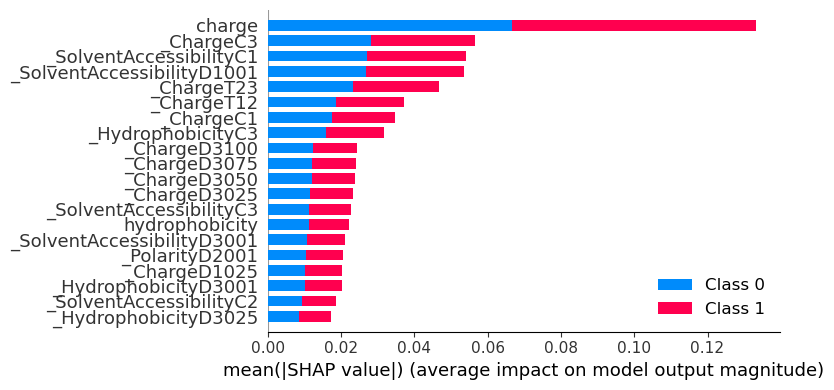

In [66]:
# Create a summary plot
shap.summary_plot(shap_values, X_test, plot_size=(8, 4))

### Preprocessing Peptides

In [41]:
lab = pd.read_excel('Peptides for Jagdish.xlsx')

In [42]:
lab.duplicated().sum()

0

In [43]:
lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608 entries, 0 to 1607
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sequence         1608 non-null   object 
 1   Function         7 non-null      object 
 2   probability_AMP  1608 non-null   float64
 3   predicted        1608 non-null   object 
 4   seq_id           1608 non-null   object 
dtypes: float64(1), object(4)
memory usage: 62.9+ KB


In [44]:
lab['Sequence'] = lab['Sequence'].apply(lambda x: x.replace('[', '').replace(']', '').replace('.', '').replace('-', ''))
lab['size'] = lab.Sequence.apply(len)
lab

,Sequence,Function,probability_AMP,predicted,seq_id,size
0,WNSGALTSGVHTFPAVLQSSGL,NaN,0.823750,AMP,hm560,22
1,WNVPIGTLRPFL,NaN,0.789062,AMP,hm1125,12
2,FAVTSILRVAA,NaN,0.760417,AMP,hm422,11
3,WNSGALTSGVHTFPAVLQSSGLY,NaN,0.757292,AMP,hm181,23
4,VSWNSGALTSGVHTFPAV,NaN,0.740625,AMP,hm694,18
...,...,...,...,...,...,...
1603,ATYLPAPEGLK,NaN,0.083750,nonAMP,hm1199,11
1604,SAEDPFIAIHAESK,NaN,0.082812,nonAMP,hm1538,14
1605,EEQVNSLPGSITK,NaN,0.081250,nonAMP,hm755,13
1606,QDEPPQSPWDR,NaN,0.078125,nonAMP,hm879,11


In [45]:
lab = lab.drop(columns=['Function', 'seq_id', 'predicted','probability_AMP'])
lab = lab.drop(lab[lab['size'] > 30].index)  # train and test only covers peptide lenght from 5 to 30 amino acids (inclusive)
lab = lab.drop(columns='size')

In [46]:
lab

,Sequence
0,WNSGALTSGVHTFPAVLQSSGL
1,WNVPIGTLRPFL
2,FAVTSILRVAA
3,WNSGALTSGVHTFPAVLQSSGLY
4,VSWNSGALTSGVHTFPAV
...,...
1603,ATYLPAPEGLK
1604,SAEDPFIAIHAESK
1605,EEQVNSLPGSITK
1606,QDEPPQSPWDR


In [47]:
ptf = Property_Transformer()
tf_lab = ptf.fit_transform(lab)
tf_lab.head()

,average_polarity,size,hydrophobicity,molecular_weight,charge,helix_frac,turn_frac,sheet_frac,_PolarizabilityC1,_PolarizabilityC2,...,_HydrophobicityD2001,_HydrophobicityD2025,_HydrophobicityD2050,_HydrophobicityD2075,_HydrophobicityD2100,_HydrophobicityD3001,_HydrophobicityD3025,_HydrophobicityD3050,_HydrophobicityD3075,_HydrophobicityD3100
0,0.409091,22,0.350000,2229.4468,-0.152724,0.227273,0.409091,0.409091,0.500,0.364,...,13.636,22.727,40.909,63.636,95.455,4.545,4.545,45.455,72.727,100.000
1,0.250000,12,0.491667,1412.6767,0.760092,0.166667,0.333333,0.583333,0.167,0.583,...,33.333,33.333,50.000,58.333,83.333,8.333,8.333,41.667,66.667,100.000
2,0.272727,11,1.718182,1147.3669,0.760092,0.363636,0.090909,0.545455,0.455,0.364,...,18.182,18.182,36.364,45.455,100.000,9.091,9.091,27.273,54.545,81.818
3,0.434783,23,0.278261,2392.6200,-0.153723,0.217391,0.391304,0.434783,0.478,0.348,...,13.043,21.739,47.826,65.217,100.000,4.348,4.348,43.478,69.565,95.652
4,0.388889,18,0.500000,1830.0048,-0.178837,0.166667,0.388889,0.444444,0.500,0.333,...,11.111,27.778,50.000,72.222,94.444,5.556,5.556,44.444,66.667,100.000


In [48]:
tf_lab[top_30_features_list]

,charge,_ChargeC3,_ChargeT23,_SolventAccessibilityC1,_ChargeT12,_ChargeD3050,_SolventAccessibilityD1001,hydrophobicity,_ChargeD3100,_ChargeD3025,...,_SolventAccessibilityD3001,_HydrophobicityT23,average_polarity,_PolarityD2001,_PolarityD1025,turn_frac,_SolventAccessibilityC2,_SecondaryStrC3,_ChargeD1025,_PolarityD1050
0,-0.152724,0.000,0.000,0.545,0.000,0.000,4.545,0.350000,0.000,0.000,...,13.636,0.381,0.409091,13.636,4.545,0.409091,0.091,0.409,0.000,45.455
1,0.760092,0.000,0.000,0.583,0.182,0.000,8.333,0.491667,0.000,0.000,...,33.333,0.455,0.250000,33.333,8.333,0.333333,0.167,0.333,75.000,41.667
2,0.760092,0.000,0.000,0.727,0.200,0.000,9.091,1.718182,0.000,0.000,...,36.364,0.500,0.272727,18.182,9.091,0.090909,0.091,0.091,72.727,27.273
3,-0.153723,0.000,0.000,0.522,0.000,0.000,4.348,0.278261,0.000,0.000,...,13.043,0.409,0.434783,13.043,26.087,0.391304,0.087,0.391,0.000,56.522
4,-0.178837,0.000,0.000,0.556,0.000,0.000,5.556,0.500000,0.000,0.000,...,11.111,0.529,0.388889,11.111,5.556,0.388889,0.056,0.389,0.000,44.444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,-0.203313,0.091,0.200,0.455,0.100,72.727,9.091,-0.163636,72.727,72.727,...,18.182,0.300,0.363636,9.091,90.909,0.272727,0.182,0.273,100.000,27.273
1604,-2.446937,0.214,0.308,0.429,0.077,21.429,14.286,-0.257143,85.714,85.714,...,7.143,0.308,0.500000,7.143,64.286,0.285714,0.286,0.286,100.000,42.857
1605,-1.161361,0.154,0.083,0.308,0.083,7.692,30.769,-0.746154,15.385,15.385,...,46.154,0.333,0.615385,46.154,84.615,0.384615,0.385,0.385,100.000,30.769
1606,-2.234856,0.273,0.300,0.091,0.000,18.182,81.818,-2.590909,90.909,90.909,...,36.364,0.100,0.636364,36.364,81.818,0.545455,0.545,0.545,100.000,81.818


### Predicting

In [49]:
# 1. Generate predictions
predictions = rf.predict(tf_lab[top_30_features_list])

# 2. Generate probabilities
probabilities = rf.predict_proba(tf_lab[top_30_features_list])[:,1]

# 3. Combine predictions and probabilities
results = list(zip(predictions, probabilities))

# Create a new DataFrame with sequence, predictions, and probabilities
result_df = pd.DataFrame(results, columns=['Prediction', 'Probabilities'])

# Concatenate the sequence column from df_new to result_df
result_df['Sequence'] = lab['Sequence']

# Reorder the columns if needed
result_df[['Sequence', 'Prediction', 'Probabilities']]

result_df

,Prediction,Probabilities,Sequence
0,0,0.460530,WNSGALTSGVHTFPAVLQSSGL
1,1,0.761031,WNVPIGTLRPFL
2,1,0.719933,FAVTSILRVAA
3,0,0.459808,WNSGALTSGVHTFPAVLQSSGLY
4,1,0.500605,VSWNSGALTSGVHTFPAV
...,...,...,...
1588,0,0.161463,IYEAGLAPYK
1589,0,0.035008,LIDEDDIPVR
1590,0,0.119546,HSDVIDSQELSK
1591,0,0.188722,QAPGQGLEWMG


In [50]:
# Predicted AMPs accounts for 2% from the 1608 peptides
result_df.Prediction.mean()

0.023854362837413684

In [51]:
result_df.Prediction.sum()

38

In [52]:
# These are predicted AMPs
my_predict_AMP = result_df[result_df.Prediction == 1].sort_values(by='Probabilities', ascending=False)
my_predict_AMP

,Prediction,Probabilities,Sequence
1,1,0.761031,WNVPIGTLRPFL
2,1,0.719933,FAVTSILRVAA
20,1,0.718212,QVPQPIPQT
99,1,0.690869,FISADDVPGSNITGIC
5,1,0.674915,WNVPIGTLRPF
124,1,0.650761,YLGPQYVAGITN
68,1,0.632579,FIFPPSDEQLKSGTASVV
346,1,0.630783,WKVDNALQSGNSQESVTEQDSKDSTYS
105,1,0.630515,NaN
181,1,0.614174,LKPEPELVYEDLRGSVTF


In [53]:
my_predict_Sequence = my_predict_AMP.Sequence
my_AMP_sequence = set(my_predict_Sequence)

In [54]:
lab = pd.read_excel('Peptides for Jagdish.xlsx')
lab['Sequence'] = lab['Sequence'].apply(lambda x: x.replace('[', '').replace(']', '').replace('.', '').replace('-', ''))
lab['size'] = lab.Sequence.apply(len)
lab_predict_AMP = lab[lab.predicted == 'AMP']
lab_AMP_sequence = lab_predict_AMP.Sequence
lab_AMP_sequence = set(lab_AMP_sequence)

In [55]:
# Find the overlap
overlap_set = my_AMP_sequence & lab_AMP_sequence
overlap_count = len(overlap_set)

if overlap_count > 0:
    print(f"Two predictions overlap.\nNumber of overlapping AMPs: {overlap_count}")
    print("Overlapping AMPs", overlap_set)
else:
    print("The sets do not overlap.")

Two predictions overlap.
Number of overlapping AMPs: 17
Overlapping AMPs {'VSWNSGALTSGVHTFPAV', 'WNVPIGTLRPF', 'WNSGALTSGVHTFPAVL', 'YPVTQPLAPVHNPISV', 'WLQGSQELPREKYLT', 'QVPQPIPQT', 'LLNPTHQIYPVTQPLAPVH', 'FVNEESTIPRSPTVVKGVAGGSVAVL', 'FIFPPSDEQLKSGTASVVC', 'FAVTSILRVAA', 'FIFPPSDEQLKSGTASVV', 'WNVPIGTLRPFL', 'FAVTSILRVAAEDW', 'RITYVPITGGTPS', 'YSLSSVVTVPSSSLG', 'WNSGALTSGVHTFPAV', 'WIYGGAFLMGSGHGANF'}


In [56]:
# Find elements only in my_AMP_sequence

unique_to_my_AMP = my_AMP_sequence - lab_AMP_sequence
print("AMPs only in my prediction:", len(unique_to_my_AMP))
print("Elements only in my_AMP:", unique_to_my_AMP)

AMPs only in my prediction: 21
Elements only in my_AMP: {nan, 'QYVPFPPFSDISNPTA', 'FISADDVPGSNITGIC', 'YLGPQYVAGITN', 'LQPLMQQVPQPIPQTL', 'DIVMTQSPLS', 'LKPEPELVYEDLRGSVTF', 'WKVDNALQSGNSQESVTEQDSKDSTYS', 'LLYPFPKD', 'QQVPQPIPQTL', 'WEVEVGDRTDWA', 'ALFILPDQDKM', 'LLVDSEGWVKAQY', 'CLVQGFFPQEPLSVTW', 'DIQYPDATDEDITS', 'YDIAQDAPDGLA', 'RRHPYFYAPELLFFAKR', 'WVRQAPGQGLEWMGI', 'RILLNPQDKDGSFSVVITG', 'CPAWIPELNSV', 'WLQGSQELPREKYL'}


### XGBoost

In [57]:
df_train = transformed_train
df_test = transformed_test

In [58]:
X_train = df_train.copy()
X_test = df_test.copy()

In [59]:
df_train = transformed_train
df_test = transformed_test
xgb = XGBClassifier(random_state=42, 
                    n_jobs=-1,
#                     gamma=0.2,
#                     learning_rate=0.1,
#                     max_depth=7,
#                     n_estimators=100,
#                     subsample=0.8,
#                     min_child_weight=1
                   )
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

report = classification_report(y_train, y_train_pred)
print(report)

report = classification_report(y_test, y_test_pred)
print(report)

y_train_proba = xgb.predict_proba(X_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_proba)
print('Train AUC: %.3f' % roc_auc_train)

auc_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='roc_auc')
average_auc = np.mean(auc_scores)
# print("AUC Scores:", auc_scores)
print("Average Train AUC-ROC from CV:", average_auc)

y_test_proba = xgb.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print('Test AUC: %.3f' % roc_auc_test)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1331
           1       0.91      0.95      0.93      1265

    accuracy                           0.93      2596
   macro avg       0.93      0.93      0.93      2596
weighted avg       0.93      0.93      0.93      2596

              precision    recall  f1-score   support

           0       0.65      0.72      0.68       292
           1       0.75      0.68      0.71       358

    accuracy                           0.70       650
   macro avg       0.70      0.70      0.70       650
weighted avg       0.71      0.70      0.70       650

Train AUC: 0.991
Average Train AUC-ROC from CV: 0.7820743680937032
Test AUC: 0.782


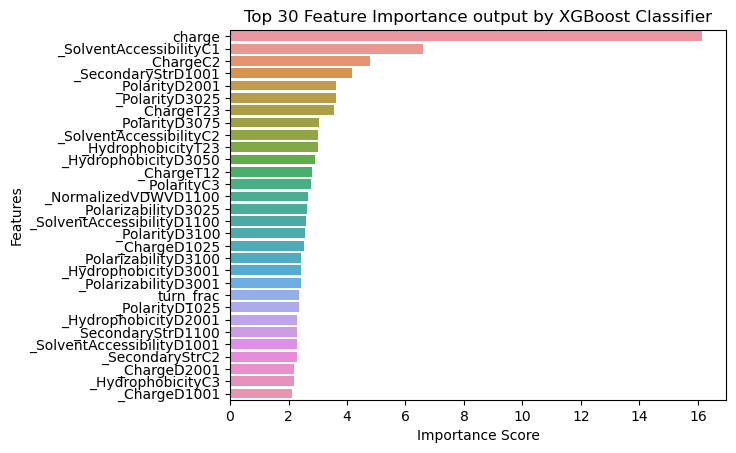

Top 30 Features: ['charge', '_SolventAccessibilityC1', '_ChargeC2', '_SecondaryStrD1001', '_PolarityD2001', '_PolarityD3025', '_ChargeT23', '_PolarityD3075', '_SolventAccessibilityC2', '_HydrophobicityT23', '_HydrophobicityD3050', '_ChargeT12', '_PolarityC3', '_NormalizedVDWVD1100', '_PolarizabilityD3025', '_SolventAccessibilityD1100', '_PolarityD3100', '_ChargeD1025', '_PolarizabilityD3100', '_HydrophobicityD3001', '_PolarizabilityD3001', 'turn_frac', '_PolarityD1025', '_HydrophobicityD2001', '_SecondaryStrD1100', '_SolventAccessibilityD1001', '_SecondaryStrC2', '_ChargeD2001', '_HydrophobicityC3', '_ChargeD1001']


In [60]:
feature_important = xgb.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=['score']).nlargest(30, columns='score')

sns.barplot(x='score', y=data.index, data=data)

plt.title('Top 30 Feature Importance output by XGBoost Classifier')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Export the feature names to a Python list
top_30_features_list = data.index.tolist()

# Print or use the list as needed
print("Top 30 Features:", top_30_features_list)

### XGB after tunning features, hyperparameters

In [61]:
X_train = X_train[top_30_features_list]
X_test = X_test[top_30_features_list]

In [62]:
X_train.head()

,charge,_SolventAccessibilityC1,_ChargeC2,_SecondaryStrD1001,_PolarityD2001,_PolarityD3025,_ChargeT23,_PolarityD3075,_SolventAccessibilityC2,_HydrophobicityT23,...,_PolarizabilityD3001,turn_frac,_PolarityD1025,_HydrophobicityD2001,_SecondaryStrD1100,_SolventAccessibilityD1001,_SecondaryStrC2,_ChargeD2001,_HydrophobicityC3,_ChargeD1001
0,0.893366,0.190,1.000,9.524,4.762,23.810,0.000,71.429,0.000,0.000,...,9.524,0.380952,0.000,4.762,100.000,4.762,0.000,4.762,0.000,0.000
1,1.844279,0.263,0.895,31.579,15.789,31.579,0.000,47.368,0.211,0.333,...,5.263,0.473684,5.263,5.263,73.684,10.526,0.316,5.263,0.211,36.842
2,-0.295189,0.567,0.867,6.667,3.333,20.000,0.103,83.333,0.200,0.483,...,33.333,0.333333,26.667,3.333,83.333,3.333,0.533,3.333,0.467,76.667
3,-0.041349,0.571,0.857,50.000,7.143,21.429,0.077,64.286,0.286,0.385,...,14.286,0.500000,14.286,7.143,92.857,14.286,0.286,7.143,0.357,64.286
4,2.847079,0.643,0.821,10.714,35.714,10.714,0.037,57.143,0.214,0.296,...,3.571,0.178571,7.143,35.714,89.286,3.571,0.214,3.571,0.357,10.714


In [63]:
X_test.head()

,charge,_SolventAccessibilityC1,_ChargeC2,_SecondaryStrD1001,_PolarityD2001,_PolarityD3025,_ChargeT23,_PolarityD3075,_SolventAccessibilityC2,_HydrophobicityT23,...,_PolarizabilityD3001,turn_frac,_PolarityD1025,_HydrophobicityD2001,_SecondaryStrD1100,_SolventAccessibilityD1001,_SecondaryStrC2,_ChargeD2001,_HydrophobicityC3,_ChargeD1001
0,3.737293,0.667,0.833,8.333,12.500,29.167,0.000,91.667,0.167,0.261,...,4.167,0.125000,20.833,12.500,95.833,4.167,0.458,4.167,0.542,29.167
1,0.793998,0.556,0.833,5.556,5.556,38.889,0.118,50.000,0.278,0.353,...,50.000,0.277778,16.667,5.556,100.000,5.556,0.167,5.556,0.333,50.000
2,0.802163,0.542,0.875,25.000,12.500,45.833,0.087,91.667,0.125,0.435,...,16.667,0.166667,8.333,12.500,95.833,4.167,0.375,4.167,0.417,91.667
3,0.759103,0.786,0.929,14.286,21.429,100.000,0.000,100.000,0.071,0.538,...,100.000,0.357143,14.286,21.429,100.000,7.143,0.214,7.143,0.571,100.000
4,-0.216384,0.185,0.333,3.704,0.000,22.222,0.385,70.370,0.815,0.000,...,3.704,0.074074,11.111,0.000,100.000,11.111,0.074,11.111,0.185,3.704


In [64]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
# grid_search_xgb.fit(X_train, y_train)
# print("Best Parameters: ", grid_search_xgb.best_params_)
# print("Best Score: ", grid_search_xgb.best_score_)
# best_xgb = grid_search_xgb.best_estimator_

# # Best Parameters:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
# # Best Score:  0.8189747028226961

In [65]:
xgb = XGBClassifier(random_state=42, 
                    n_jobs=-1,
                    learning_rate=0.2,
                    max_depth=3,
                    n_estimators=50,
                   )
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

report = classification_report(y_train, y_train_pred)
print(report)

report = classification_report(y_test, y_test_pred)
print(report)

y_train_proba = xgb.predict_proba(X_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_proba)
print('Train AUC: %.3f' % roc_auc_train)

auc_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='roc_auc')
average_auc = np.mean(auc_scores)
# print("AUC Scores:", auc_scores)
print("Average Train AUC-ROC from CV:", average_auc)

y_test_proba = xgb.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print('Test AUC: %.3f' % roc_auc_test)

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1331
           1       0.78      0.87      0.82      1265

    accuracy                           0.82      2596
   macro avg       0.82      0.82      0.82      2596
weighted avg       0.82      0.82      0.82      2596

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       292
           1       0.77      0.78      0.78       358

    accuracy                           0.75       650
   macro avg       0.75      0.75      0.75       650
weighted avg       0.75      0.75      0.75       650

Train AUC: 0.908
Average Train AUC-ROC from CV: 0.8189747028226961
Test AUC: 0.819


### Predicting

In [66]:
# 1. Generate predictions
predictions = xgb.predict(tf_lab[top_30_features_list])

# 2. Generate probabilities
probabilities = xgb.predict_proba(tf_lab[top_30_features_list])[:,1]

# 3. Combine predictions and probabilities
results = list(zip(predictions, probabilities))

# Create a new DataFrame with sequence, predictions, and probabilities
result_df = pd.DataFrame(results, columns=['Prediction', 'Probabilities'])

# Concatenate the sequence column from df_new to result_df
result_df['Sequence'] = lab['Sequence']

# Reorder the columns if needed
result_df[['Sequence', 'Prediction', 'Probabilities']]

result_df

,Prediction,Probabilities,Sequence
0,1,0.619204,WNSGALTSGVHTFPAVLQSSGL
1,1,0.849418,WNVPIGTLRPFL
2,1,0.835614,FAVTSILRVAA
3,1,0.531376,WNSGALTSGVHTFPAVLQSSGLY
4,1,0.648970,VSWNSGALTSGVHTFPAV
...,...,...,...
1588,0,0.178443,IYEAGLAPYK
1589,0,0.069705,LIDEDDIPVR
1590,0,0.029843,HSDVIDSQELSK
1591,0,0.054737,QAPGQGLEWMG


In [67]:
# Predicted AMPs accounts for 2% from the 1608 peptides
result_df.Prediction.mean()

0.07344632768361582

In [68]:
result_df.Prediction.sum()

117

In [69]:
# These are predicted AMPs
my_predict_AMP = result_df[result_df.Prediction == 1].sort_values(by='Probabilities', ascending=False)
my_predict_AMP

,Prediction,Probabilities,Sequence
974,1,0.891701,ALFILPDQDKM
995,1,0.858655,DIVMTQSPLS
1,1,0.849418,WNVPIGTLRPFL
262,1,0.846786,WVRQAPGQGLEWMGI
2,1,0.835614,FAVTSILRVAA
...,...,...,...
524,1,0.508109,LAEIDGIELT
618,1,0.504797,YLNIWVPQGR
1310,1,0.503779,HMWPGDIKA
629,1,0.503012,NVTDPSLDLT


In [70]:
my_predict_Sequence = my_predict_AMP.Sequence
my_AMP_sequence = set(my_predict_Sequence)

In [71]:
lab = pd.read_excel('Peptides for Jagdish.xlsx')
lab['Sequence'] = lab['Sequence'].apply(lambda x: x.replace('[', '').replace(']', '').replace('.', '').replace('-', ''))
lab['size'] = lab.Sequence.apply(len)
lab_predict_AMP = lab[lab.predicted == 'AMP']
lab_AMP_sequence = lab_predict_AMP.Sequence
lab_AMP_sequence = set(lab_AMP_sequence)

In [72]:
# Find the overlap
overlap_set = my_AMP_sequence & lab_AMP_sequence
overlap_count = len(overlap_set)

if overlap_count > 0:
    print(f"Two predictions overlap.\nNumber of overlapping AMPs: {overlap_count}")
    print("Overlapping AMPs", overlap_set)
else:
    print("The sets do not overlap.")

Two predictions overlap.
Number of overlapping AMPs: 26
Overlapping AMPs {'RQYLPNSHPPTVVR', 'WNSGALTSGVHTFPAVLQSSGLY', 'WIYGGAFLMGSGHGANF', 'WLQGSQELPREKYLT', 'FVNEESTIPRSPTVVKGVAGGSVAVL', 'LSLHRPALEDLL', 'FIFPPSDEQLKSGTASVV', 'WNVPIGTLRPFL', 'RITYVPITGGTPS', 'YSLSSVVTVPSSSLG', 'VKHEDQQQGEDEHQDKIYPSFQPQPLI', 'ISELQLSVSAGSPHPAI', 'WNVPIGTLRPF', 'WNSGALTSGVHTFPAVLQSSGL', 'WNSGALTSGVHTFPAVL', 'YPVTQPLAPVHNPISV', 'YSLSSVVTVPSSSLGTQTYI', 'FIFPPSDEQLKSGTASVVC', 'FAVTSILRVAA', 'YLISSIPLQGAFNY', 'FAVTSILRVAAEDW', 'WNSGALTSGVHTFPAV', 'RASGVPDRFSGSGSGTDFT', 'VSWNSGALTSGVHTFPAV', 'QVPQPIPQT', 'LLNPTHQIYPVTQPLAPVH'}


In [73]:
# Find elements only in my_AMP_sequence

unique_to_my_AMP = my_AMP_sequence - lab_AMP_sequence
print("AMPs only in my prediction:", len(unique_to_my_AMP))
print("Elements only in my_AMP:", unique_to_my_AMP)

AMPs only in my prediction: 90
Elements only in my_AMP: {'LYASPDVSEPIDGLNPNEE', 'AEIVTEAEPEVDNLL', 'LENPQPHPGWQGTL', 'LAEIDGIELT', 'DIVMTQSPLS', 'SYELTQPPSVSVSPGQTAR', 'LKPEPELVYEDLRGSVTF', 'CLVQGFFPQEPL', 'TIPFFDPQI', 'NLDEDIIAEENIVSR', 'KQIGLYPVLVI', 'WYYPQIMQ', 'KQVGSGVTTDQVQAEAK', 'FQDDFVIPDISEPGTW', 'AIVENNESTEY', 'LMQQVPQPIPQ', 'WVRQAPGQGLEWMGI', 'QPAVVLPVPQPEI', 'YLNIWVPQGR', 'RKANDESNEHSDVIDSQE', 'KALENPQPHPGWQGTLK', 'RNDVVFQPISGEDVR', 'YVSATVILHSGSDMVQAERS', 'YLFIQTDKTIY', 'LQPLMQQVPQPIPQ', 'LPILNQPSTQ', 'AIVENNESTEYG', 'FSVVITGLRKEDAGR', 'FQTPQHPSFLFQDKR', 'FVNEESTIPRSPTVVKG', 'CLVQGFFPQEPLSVTW', 'FIYEAGLAPY', 'KSGTSASLAISGLR', 'HLLPPPSEELALNE', 'MEEIENAFQGNLC', 'LPELPDVELPTN', 'RILLNPQDKDGSFSVVITG', 'RLSLHRPALEDLL', 'LLQDNIADAVA', 'LSKSGNTFRPEVHL', 'KAGVETTTPSKQSNNKYA', 'RHYWEVEVG', 'TGFAPDTDDLKQ', 'FRPEVHLLPPPSEELA', 'LSFDVSLEVSQGPGL', 'VFDTGSSNLWV', 'FISADDVPGSNITGIC', 'YLGPQYVAGITN', 'FISADDVPGSNITGI', 'WKVDNALQSGNSQESVTEQDSKDSTYS', 'QPAVVLPVPQPEIME', 'LAKADAAPDEKV', 'YSI

## Functions

In [100]:
# # Get physicochemical properties
# class Property_Transformer(object):
    
#     def __init__(self):
#         # Polarity values for amino acids (1 for polar, 0 for nonpolar)
#         self.polarity_values = {'A': 0, 'R': 1, 'N': 1, 'D': 1, 'C': 1, 'Q': 1, 'E': 1, 'G': 0, 'H': 1, 'I': 0,
#                                 'L': 0, 'K': 1, 'M': 0, 'F': 0, 'P': 0, 'S': 1, 'T': 1, 'W': 0, 'Y': 1, 'V': 0}
        
#         # reference: charge_values = {'D': -1, 'E': -1, 'K': 1, 'R': 1, 'H': 0.5, 'other aa':0}, charge result is the sum of all the values

        
#     def fit(self, X, y=None):
#         pass # No training needed
        
#     def transform(self, X, y=None):
#         X['average_polarity'] = X['Sequence'].apply(self.calculate_average_polarity)
#         X['size'] = X['Sequence'].apply(len)
#         X['hydrophobicity'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).gravy()) 
#         X['molecular_weight'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).molecular_weight())
#         X['charge'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).charge_at_pH(7.0))
#         X['second_structure'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).secondary_structure_fraction())
#         X['second_structure'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).secondary_structure_fraction())
#         X[['helix_frac', 'turn_frac', 'sheet_frac']] = X['second_structure'].apply(pd.Series) # split the 'second_structure' column into 3 new columns
        
#         return X
    
#     def fit_transform(self, X, y=None):
#         return self.transform(X)
    
#     def calculate_average_polarity(self, sequence):
#         # Calculate polarity for each amino acid in the sequence
#         polarities = [self.polarity_values.get(aa, 0) for aa in sequence]
#         average_polarity = sum(polarities) / len(sequence)
#         return average_polarity

In [101]:
# train['Features'] = None  # Create a new column to store the features

# for index, row in train.iterrows():
#     protein_sequence = row['Sequence']
#     result = CalculateCTD(protein_sequence)

#     # Assign the entire dictionary to the 'Features' column
#     train.at[index, 'Features'] = result

# # Expand the 'Features' column into separate feature columns
# train = pd.concat([train, train['Features'].apply(pd.Series)], axis=1)

# # Drop the original 'Features' column if needed
# train = train.drop(columns=['Features'])

In [102]:
# class CTD_Transformer(object):
    
#     def __init__(self):
#         pass  # No initialization needed
    
#     def fit(self, X, y=None):
#         pass  # No training needed
        
#     def transform(self, X, y=None):
#         X['Features'] = X['Sequence'].apply(self.calculate_ctd_features)

#         # Expand the 'Features' column into separate feature columns
#         X = pd.concat([X, X['Features'].apply(pd.Series)], axis=1)

#         # Drop the original 'Features' column if needed
#         X = X.drop(columns=['Features'])
        
#         return X
    
#     def fit_transform(self, X, y=None):
#         return self.transform(X)
    
#     def calculate_ctd_features(self, sequence):
#         # Use propy.CTD.CalculateD to get features for the given sequence
#         result = CalculateCTD(sequence)
#         return result


In [103]:
# def plot_histograms(dataframe):
#     sns.set(style="darkgrid")
#     dataframe = dataframe.drop(columns=['Sequence', 'second_structure'])
#     features = dataframe.columns.tolist()
#     features.remove('Label')

#     # Set the number of subplots and their arrangement
#     num_subplots = len(features)
#     num_cols = 3  # You can change the number of columns based on your preference
#     num_rows = (num_subplots - 1) // num_cols + 1

#     # Set the size of the figure
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), dpi=150)

#     # Flatten axes in case there is only one row
#     axes = axes.flatten()

#     # Loop through each column and plot the histogram
#     for i, column in enumerate(features):
#         ax = axes[i]
#         sns.histplot(data=dataframe[dataframe.Label==1], x=column, ax=ax, kde=True, color='blue')
#         sns.histplot(data=dataframe[dataframe.Label==0], x=column, ax=ax, kde=True, color='red')
#         ax.set_title(f'Histogram of {column}')
#         ax.set_xlabel(column)
#         ax.set_ylabel('Count')

#     # remove empty subplots
#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])
    
#     # Adjust layout to prevent overlapping
#     plt.tight_layout()
#     plt.show()

In [104]:
#  plot_histograms(train)

# correlation = train.corr()
# plt.figure(figsize=(12, 4), dpi=150)
# sns.heatmap(correlation,cmap='coolwarm', annot=True) 
# plt.show()

In [105]:
# # Assuming 'X' is your feature matrix containing the top 30 features
# # and 'y' is your target variable

# # Extract the top 30 features from your DataFrame
# X_top_50 = X_train[top_50_features_list]

# # Add a constant term for the intercept
# X_top_50 = sm.add_constant(X_top_50)

# # Calculate VIF for each feature
# vif_data = pd.DataFrame()
# vif_data["Feature"] = X_top_50.columns
# vif_data["VIF"] = [variance_inflation_factor(X_top_50.values, i) for i in range(X_top_50.shape[1])]
# print(vif_data)

# # Identify features with high VIF
# high_vif_features = vif_data[vif_data["VIF"] >= 5]["Feature"].tolist()
# high_vif_features.remove('const')
# print("Features with high VIF:", high_vif_features)